In [ ]:
# Predict the price of the Uber ride from a given pickup point to the agreed drop-off location. 
# Perform following tasks: 
#     1. Pre-process the dataset. 
#     2. Identify outliers. 
#     3. Check the correlation. 
#     4. Implement linear regression and random forest regression models. 
#     5. Evaluate the models and compare their respective scores like R2, RMSE, etc.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic

In [2]:
df = pd.read_csv("uber.csv")


In [ ]:
df.isnull().sum()

In [3]:
df.dropna(inplace=True)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month

In [4]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,day_of_week,month
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,3,5
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,4,7
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,0,8
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,4,6
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,10,28,6,10
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1,14,4,3
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0,29,0,6
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,14,20,2,5


In [5]:
# Filter out invalid latitude and longitude values
df = df[(df['pickup_latitude'].between(-90, 90)) &
        (df['pickup_longitude'].between(-180, 180)) &
        (df['dropoff_latitude'].between(-90, 90)) &
        (df['dropoff_longitude'].between(-180, 180))]
df['distance'] = df.apply(lambda row: geodesic((row['pickup_latitude'], row['pickup_longitude']),
                                               (row['dropoff_latitude'], row['dropoff_longitude'])).km, axis=1)

C:\Users\Soham Padwal\AppData\Local\Temp\ipykernel_18704\1419331388.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: geodesic((row['pickup_latitude'], row['pickup_longitude']),


In [6]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,day_of_week,month,distance
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,3,5,1.681111
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,4,7,2.454363
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,0,8,5.039603
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,4,6,1.661442
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,3,8,4.483730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,10,28,6,10,0.112128
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1,14,4,3,1.879635
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0,29,0,6,12.867916
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,14,20,2,5,3.536552


In [7]:
df.drop(['key','pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)

C:\Users\Soham Padwal\AppData\Local\Temp\ipykernel_18704\1909722437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['key','pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)


In [8]:
df['fare_amount'] = 

,Unnamed: 0,fare_amount,passenger_count,hour,day,day_of_week,month,distance
0,24238194,7.5,1,19,7,3,5,1.681111
1,27835199,7.7,1,20,17,4,7,2.454363
2,44984355,12.9,1,21,24,0,8,5.039603
3,25894730,5.3,3,8,26,4,6,1.661442
4,17610152,16.0,5,17,28,3,8,4.483730
...,...,...,...,...,...,...,...,...
199995,42598914,3.0,1,10,28,6,10,0.112128
199996,16382965,7.5,1,1,14,4,3,1.879635
199997,27804658,30.9,2,0,29,0,6,12.867916
199998,20259894,14.5,1,14,20,2,5,3.536552


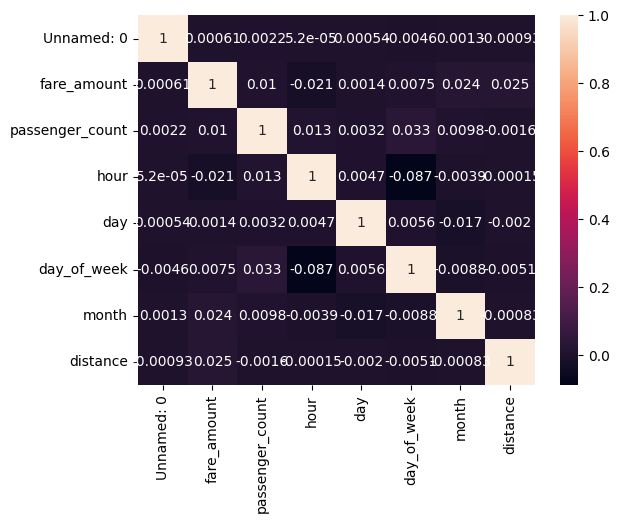

In [9]:
sns.heatmap(df.corr(), annot=True)
plt.show()

In [10]:
X = df.drop(['fare_amount'], axis=1)
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Linear Regression Model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)

In [12]:
# Random Forest Regression Model
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

In [13]:
# Evaluation
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} - R2: {r2:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regression")

Linear Regression - R2: 0.00, RMSE: 9.57, MAE: 5.99
Random Forest Regression - R2: 0.75, RMSE: 4.78, MAE: 2.39
